# ML Pipeline - The Oracle 🔮
## Valencia Traffic Platform

En este notebook implementaremos el pipeline de entrenamiento enfocándonos en:
1. **Feature Engineering** robusto (cíclico + lags).
2. **Manejo de Desbalanceo** mediante Class Weights.
3. **Evaluación** basada en métricas de retención de estados minoritarios (1, 2, 3).

In [4]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

# Añadir src al path para importar el data_loader
sys.path.append(os.path.abspath("../"))
from src.refining.data_loader import load_historical_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Data Preparation & Feature Engineering
Consolidamos la lógica validada en el EDA.

In [5]:
def prepare_data(df):
    df = df.copy()
    df['dt'] = pd.to_datetime(df['ingested_at'])
    df['dt_rounded'] = df['dt'].dt.round('5min')
    
    # Temporal features
    df['hour'] = df['dt_rounded'].dt.hour
    df['day_of_week'] = df['dt_rounded'].dt.dayofweek
    
    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Limpieza (Estado 9 = Sin datos)
    df = df[df['estado'] != 9].copy()
    
    # Lags por tramo (idtramo)
    df = df.sort_values(['idtramo', 'dt_rounded'])
    
    ml_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']
    for lag in [1, 2, 3]:
        col_name = f'estado_lag_{lag}'
        df[col_name] = df.groupby('idtramo')['estado'].shift(lag)
        ml_features.append(col_name)
    
    # Dropna selectivo: solo columnas críticas para ML
    # Esto evita vaciar el dataset por NaNs en denominacion o geo_point
    return df.dropna(subset=ml_features + ['estado'])

df_raw = load_historical_data("../data/raw/2025")
data = prepare_data(df_raw)
print(f"Dataset preparado: {data.shape}")

2025-12-26 20:57:10,371 - INFO - Loading 734 files from ../data/raw/2025...
2025-12-26 20:57:15,035 - ERROR - Error processing ..\data\raw\2025\12\22\traffic_230005.json: Expecting ',' delimiter: line 4106 column 30 (char 98282)
2025-12-26 20:57:15,242 - INFO - Total records loaded: 75958
2025-12-26 20:57:15,245 - INFO - Columns found: ['gid', 'denominacion', 'estado', 'idtramo', 'geo_shape', 'geo_point_2d', 'geo_shape.type', 'geo_shape.geometry.coordinates', 'geo_shape.geometry.type', 'geo_point_2d.lon', 'geo_point_2d.lat', 'ingested_at']


Dataset preparado: (70675, 23)


### 2. Definición del Target y Split

In [6]:
features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'estado_lag_1', 'estado_lag_2', 'estado_lag_3']
X = data[features]
y = data['estado']

# Shuffle=False para mantener la temporalidad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Entrenamiento: {X_train.shape}, Test: {X_test.shape}")

Entrenamiento: (56540, 7), Test: (14135, 7)


### 3. Manejo de Desbalanceo: Class Weights
Calculamos pesos para equilibrar el 96% de fluidez.

In [7]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, weights))

print("Pesos para el modelo:")
for c, w in class_weights_dict.items():
    print(f"Estado {c}: {w:.4f}")

Pesos para el modelo:
Estado 0.0: 0.2057
Estado 1.0: 8.6851
Estado 2.0: 81.9420
Estado 3.0: 282.7000
Estado 4.0: 121.5914


### 4. Entrenamiento del Champion: XGBoost Weighted

In [8]:
sample_weights = np.array([class_weights_dict[val] for val in y_train])

champion_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    objective='multi:softprob'
)

champion_model.fit(X_train, y_train, sample_weight=sample_weights)
print("Modelo Champion (XGBoost) entrenado con pesos.")

Modelo Champion (XGBoost) entrenado con pesos.


### 5. Evaluación Exhaustiva

--- classification_report ---
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97     13605
         1.0       0.26      0.74      0.39        31
         2.0       0.00      0.00      0.00         0
         3.0       0.54      0.88      0.67       484
         4.0       0.16      1.00      0.28        15

    accuracy                           0.93     14135
   macro avg       0.39      0.71      0.46     14135
weighted avg       0.98      0.93      0.95     14135



c:\Users\lrguardamagna\Documents\proyects\data_engineering\envdata\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\lrguardamagna\Documents\proyects\data_engineering\envdata\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\lrguardamagna\Documents\proyects\data_engineering\envdata\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _

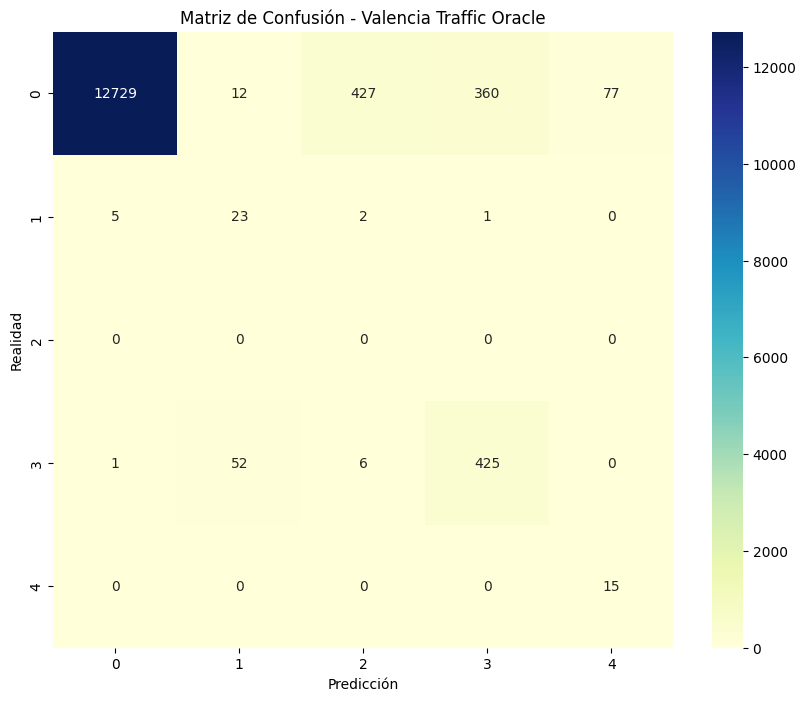

In [9]:
preds = champion_model.predict(X_test)

print("--- classification_report ---")
print(classification_report(y_test, preds))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Matriz de Confusión - Valencia Traffic Oracle')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()